# Assignment 3 — Text Classification & Sentiment Analysis
**Objectives**
- Implement text classification using traditional ML (Logistic Regression)
- Apply preprocessing (tokenization, stopword removal, lemmatization)
- Create features (Bag-of-Words, TF-IDF)
- Train and evaluate a sentiment classifier
- Analyze failures due to sarcasm/ambiguity and discuss improvements


In [1]:
# Install required packages (uncomment in Colab)
# !pip install scikit-learn nltk pandas matplotlib seaborn wordcloud

# Imports
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from collections import Counter

from nltk.corpus import stopwords, movie_reviews
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

logging.basicConfig(level=logging.INFO, format='%(message)s')
log = logging.getLogger()


## Step 1 — Download NLTK resources
Run this cell once to ensure required NLTK data is available.


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('movie_reviews')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

## Step 2 — Load dataset (NLTK movie_reviews)
We load the NLTK `movie_reviews` corpus which contains labeled movie reviews (pos/neg).


In [3]:
# Load movie_reviews into a DataFrame
docs = []
labels = []
fileids = movie_reviews.fileids()
for fid in fileids:
    text = movie_reviews.raw(fid)
    label = movie_reviews.categories(fid)[0]  # 'pos' or 'neg'
    docs.append(text)
    labels.append(label)

df = pd.DataFrame({'text': docs, 'label': labels})
df['label_num'] = df['label'].map({'neg': 0, 'pos': 1})
log.info(f"Loaded {len(df)} documents. Example:\n")
display(df.head(2))


,text,label,label_num
0,"plot : two teen couples go to a church party ,...",neg,0
1,the happy bastard's quick movie review \ndamn ...,neg,0


## Step 3 — Preprocessing utilities
Tokenization, stopword removal, lemmatization, and a simple cleaner. Functions include basic exception handling.


In [4]:
# Preprocessing helpers
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Lowercase, remove non-alpha characters (except spaces), collapse whitespace."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text, remove_stopwords=True, do_lemmatize=True):
    """Tokenize -> (stopword removal) -> lemmatize -> join back to string."""
    try:
        text = clean_text(text)
        tokens = word_tokenize(text)
        if remove_stopwords:
            tokens = [t for t in tokens if t not in stop_words]
        if do_lemmatize:
            tokens = [lemmatizer.lemmatize(t) for t in tokens]
        return " ".join(tokens)
    except Exception as e:
        log.warning(f"Preprocessing error: {e}")
        return ""


## Step 4 — Preprocess dataset (tokenize, stopword removal, lemmatize)
This will create a `clean_text` column used for feature extraction.


In [5]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
# Apply preprocessing (this may take a few seconds)
df['clean_text'] = df['text'].apply(lambda t: preprocess_text(t))
display(df[['label','clean_text']].head(2))


,label,clean_text
0,neg,plot two teen couple go church party drink dri...
1,neg,happy bastard quick movie review damn k bug go...


## Step 5 — Feature Engineering: Bag-of-Words & TF-IDF
Create CountVectorizer and TfidfVectorizer representations and compare shapes.


In [7]:
# Split data first (use stratify to keep label balance)
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num']
)

# BoW
count_vect = CountVectorizer(max_features=5000)  # limit features for speed
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

# TF-IDF
tfidf_vect = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

print("Shapes:")
print("  BoW train:", X_train_count.shape, "test:", X_test_count.shape)
print("  TF-IDF train:", X_train_tfidf.shape, "test:", X_test_tfidf.shape)


Shapes:
  BoW train: (1600, 5000) test: (400, 5000)
  TF-IDF train: (1600, 5000) test: (400, 5000)


## Step 6 — Train classifier (Logistic Regression) on TF-IDF
We will train a logistic regression classifier on TF-IDF features and evaluate on the test set.


In [8]:
# Training with TF-IDF
clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("TF-IDF + Logistic Regression metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1-score:  {f1:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=['neg','pos']))


TF-IDF + Logistic Regression metrics:
  Accuracy:  0.8400
  Precision: 0.8208
  Recall:    0.8700
  F1-score:  0.8447

Classification report:
              precision    recall  f1-score   support

         neg       0.86      0.81      0.84       200
         pos       0.82      0.87      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



## Step 7 — Confusion Matrix Visualization
Plot a heatmap of the confusion matrix for easy interpretation.


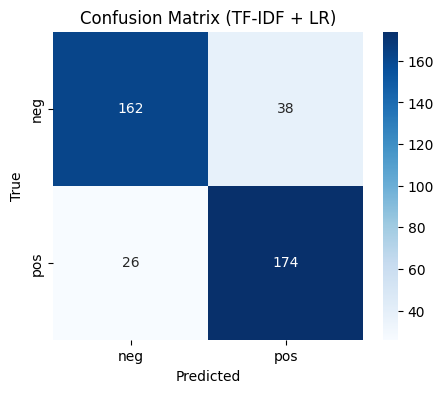

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg','pos'], yticklabels=['neg','pos'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (TF-IDF + LR)')
plt.show()


## Step 8 — Baseline: Train on Bag-of-Words for comparison
Train same classifier on BoW features to compare performance.


In [10]:
clf_bow = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
clf_bow.fit(X_train_count, y_train)
y_pred_bow = clf_bow.predict(X_test_count)

print("BoW + Logistic Regression metrics:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_bow):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_bow):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_bow):.4f}")
print(f"  F1-score:  {f1_score(y_test, y_pred_bow):.4f}")


BoW + Logistic Regression metrics:
  Accuracy:  0.8500
  Precision: 0.8398
  Recall:    0.8650
  F1-score:  0.8522


## Step 9 — Word Clouds for Positive and Negative classes
Visualize the most frequent words in each class (using cleaned text).


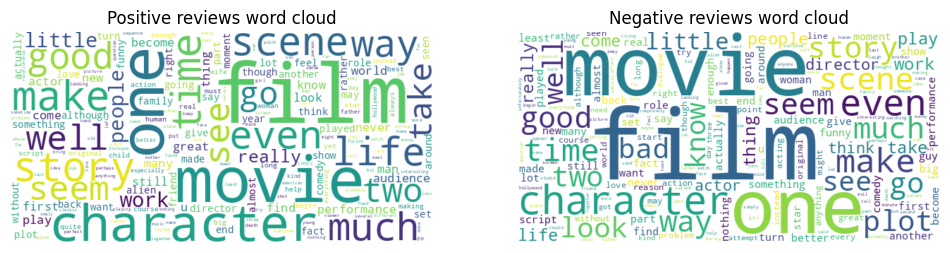

In [11]:
# Combine train texts per class for better visualization
pos_text = " ".join(df[df['label']=='pos']['clean_text'].values)
neg_text = " ".join(df[df['label']=='neg']['clean_text'].values)

wc_pos = WordCloud(width=600, height=300, background_color='white').generate(pos_text)
wc_neg = WordCloud(width=600, height=300, background_color='white').generate(neg_text)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive reviews word cloud')

plt.subplot(1,2,2)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative reviews word cloud')
plt.show()


## Step 10 — Analyze misclassifications (Sarcasm and Ambiguity)
Identify examples where the classifier failed — these often reveal sarcasm, negations, or ambiguous expressions.


In [12]:
# Find misclassified examples
test_df = pd.DataFrame({
    'text': X_test,
    'true': y_test.values,
    'pred_tfidf': y_pred,
    'pred_bow': y_pred_bow
})
# Show some misclassified examples by TF-IDF classifier
mis_tfidf = test_df[test_df['true'] != test_df['pred_tfidf']].sample(n=10, random_state=42)
for i, row in mis_tfidf.iterrows():
    print("----")
    print("True:", 'pos' if row['true']==1 else 'neg', "| Pred (TF-IDF):", 'pos' if row['pred_tfidf']==1 else 'neg', "| Pred (BoW):", 'pos' if row['pred_bow']==1 else 'neg')
    print(row['text'][:400].strip())
    print()


----
True: neg | Pred (TF-IDF): pos | Pred (BoW): pos
review spy shagged postulated unbreakable law film physic every time sequel good better previous film series followed third movie bore cause probably complacency studio sigh relief part life expectation figure part sure thing scream provides latest proof rule los angeles production begun stab return woodsboro recent installment series movie inspired murder surrounding sidney prescott neve campbell

----
True: neg | Pred (TF-IDF): pos | Pred (BoW): pos
phew mess fifth collaboration director rich ard donner lethal weapon iii maverick mel gibson play motormouth maybe mentally ill new york city cabbie jerry whose wild conspiracy theory ignored alice julia robert acting serious justice department employee crush interested another person cia psychiatrist patrick stewart promptly kidnaps one jerry conjecture correct metal strip new bill used track mov

----
True: neg | Pred (TF-IDF): pos | Pred (BoW): pos
running time approximately hr min 

## Step 11 — Discussion: Sarcasm & Ambiguity
Typical failure reasons and features that may help:
- Sarcasm: surface words may be positive but context is negative (e.g., "Great, another sequel...")  
- Negation: "not good" vs "good" — bigrams or dependency-aware features help  
- Ambiguity: short reviews without clear sentiment signal  
**Possible improvements:** use n-grams, sentiment lexicons, negation handling, POS features, contextual embeddings (BERT), or models trained on sarcasm-labeled data.


In [13]:
# Print a small summary discussion programmatically
discussion = """
Sarcasm & Ambiguity Notes:
- Sarcastic sentences often flip the apparent polarity; lexical features alone fail.
- Negation handling (e.g., "not good" vs "good") is crucial; use phrase features or dependency parsing.
- Use contextual embeddings (BERT/RoBERTa) or specialized sarcasm detectors for better performance.
"""
print(discussion)



Sarcasm & Ambiguity Notes:
- Sarcastic sentences often flip the apparent polarity; lexical features alone fail.
- Negation handling (e.g., "not good" vs "good") is crucial; use phrase features or dependency parsing.
- Use contextual embeddings (BERT/RoBERTa) or specialized sarcasm detectors for better performance.



## Step 12 — Save results and model artifacts (optional)
Save predictions and the cleaned dataset to CSV; optionally pickle the trained model.


In [14]:
# Save the cleaned dataset and predictions
out_df = df.copy()
out_df.to_csv('movie_reviews_cleaned.csv', index=False)
log.info("Saved 'movie_reviews_cleaned.csv'")

# Save test predictions
test_df_out = test_df.copy()
test_df_out['pred_tfidf_label'] = test_df_out['pred_tfidf'].map({0:'neg',1:'pos'})
test_df_out['pred_bow_label'] = test_df_out['pred_bow'].map({0:'neg',1:'pos'})
test_df_out.to_csv('movie_reviews_test_predictions.csv', index=False)
log.info("Saved 'movie_reviews_test_predictions.csv'")

# Optional: download in Colab
try:
    from google.colab import files
    files.download('movie_reviews_cleaned.csv')
    files.download('movie_reviews_test_predictions.csv')
except Exception:
    pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 13 — Conclusion
Summarize results and next steps:
- TF-IDF + Logistic Regression gives a strong baseline.
- Bag-of-Words performs similarly; TF-IDF often helps reduce influence of common words.
- To handle sarcasm and complex language, try contextual embeddings (BERT), syntax-aware features, or ensemble models.
